## Importing necessary libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

np.random.seed(2)

import keras
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
import keras.optimizers as opt 
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.layers.core import Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.layers import Input
# from keras.initializers import RandomNormal



## Mounting Google Drive for loading dataset

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## For saving the model weights, we have to install h5py

In [35]:
pip install h5py

## Loading the dataset and labelling the emotions

In [4]:
data = pd.read_csv("/content/gdrive/My Drive/Kaggle/fer2013.csv")
data.head()

emotions_names = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
data['emotion_name'] = data['emotion'].map(emotions_names)


## Grouping the dataset by their label, including train, validation and test

In [5]:
groups = [g for _, g in data.groupby('Usage')]
print(groups)
train = groups[2]
validation = groups[1]
test = groups[0]

[       emotion  ... emotion_name
32298        0  ...        Angry
32299        5  ...     Surprise
32300        6  ...      Neutral
32301        4  ...          Sad
32302        2  ...         Fear
...        ...  ...          ...
35882        6  ...      Neutral
35883        3  ...        Happy
35884        0  ...        Angry
35885        3  ...        Happy
35886        2  ...         Fear

[3589 rows x 4 columns],        emotion  ... emotion_name
28709        0  ...        Angry
28710        1  ...      Disgust
28711        4  ...          Sad
28712        6  ...      Neutral
28713        3  ...        Happy
...        ...  ...          ...
32293        4  ...          Sad
32294        3  ...        Happy
32295        4  ...          Sad
32296        4  ...          Sad
32297        4  ...          Sad

[3589 rows x 4 columns],        emotion  ... emotion_name
0            0  ...        Angry
1            0  ...        Angry
2            2  ...         Fear
3            4  ...    

## After grouping the dataset, because it's not needed anymore
## Specifying the input and output, pixels are the input and the emotions are the output

In [6]:
train = train.drop(labels=['Usage'], axis=1)
validation = validation.drop(labels=['Usage'], axis=1)
test = test.drop(labels=['Usage'], axis=1)

# print(train)

Y_train = train["emotion"]
Y_validation = validation["emotion"]
Y_test = test["emotion"]
#'Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'#

X_train = train["pixels"]
X_validation = validation["pixels"]
X_test = test["pixels"]

## Preprocess part, normalizing and reshaping the array

In [7]:
def preprocess(X):
    X = np.array([np.fromstring(image, np.uint8, sep=' ') for image in X])
    
    X = X/255.0
    #X = X/127.5 -1 
    # print(X.shape)
    X = X.reshape(-1, 48, 48, 1)
    return X

## Preprocessing each group input

In [8]:
X_train = preprocess(X_train)
X_validation = preprocess(X_validation)
X_test = preprocess(X_test)

## Showing random images from dataset after preprocessing

In [20]:
def show_random(images, Original_emotion = None, Predicted_emotion = None, random = True, indices = None):
  if random == True:
        indices = np.random.randint(0, len(images), size = 15)
  else:
        indices = np.random.choice(list(indices), size = 15, replace = False)
    
  plt.figure(figsize=(20, 14)) 
  for index, number in enumerate(indices):
        plt.subplot(3,5, index + 1)
        if (isinstance(Original_emotion, type(None)) & isinstance(Predicted_emotion, type(None))):
            plt.title('Image: ' + str(indices[index]))           
        elif (isinstance(Original_emotion, type(None)) & ~isinstance(Predicted_emotion, type(None))):
            plt.title('Image: ' + str(indices[index]) + '\n' + 'Predicted emotion:' + Predicted_emotion[indices[index]])
        elif (~isinstance(Original_emotion, type(None)) & isinstance(Predicted_emotion, type(None))):
             plt.title('Image: ' + str(indices[index]) + '\n' + 'Original emotion: ' + Original_emotion[indices[index]])           
        else:
            plt.title('Image: ' + str(indices[index]) + '\n' + 'Original emotion: ' + Original_emotion[indices[index]] + 
                      '\n' + 'Predicted emotion:' + Predicted_emotion[indices[index]])
        show_image = images[number].reshape(48,48)
        plt.axis('off')
        plt.imshow(show_image, cmap='gray')

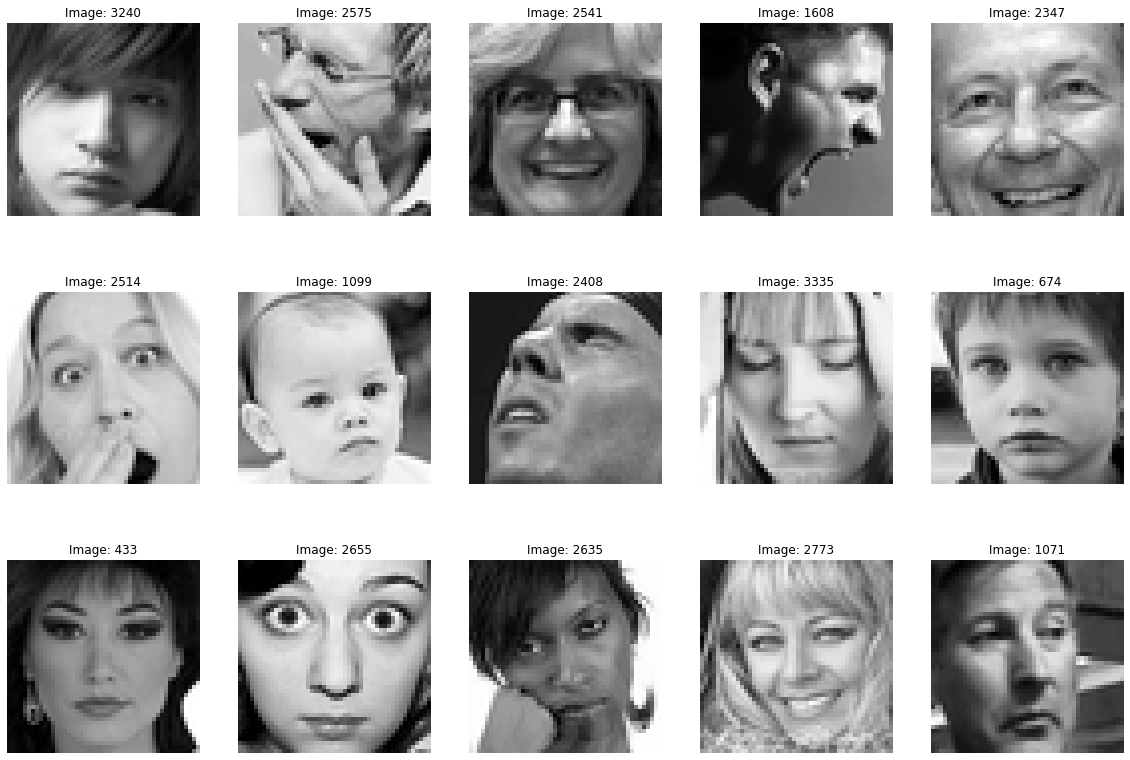

In [ ]:
show_random(X_validation)

## Plotting each group based on emotion labels, in order to know the number of images for each emotion

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Counts per emotion in testing set')

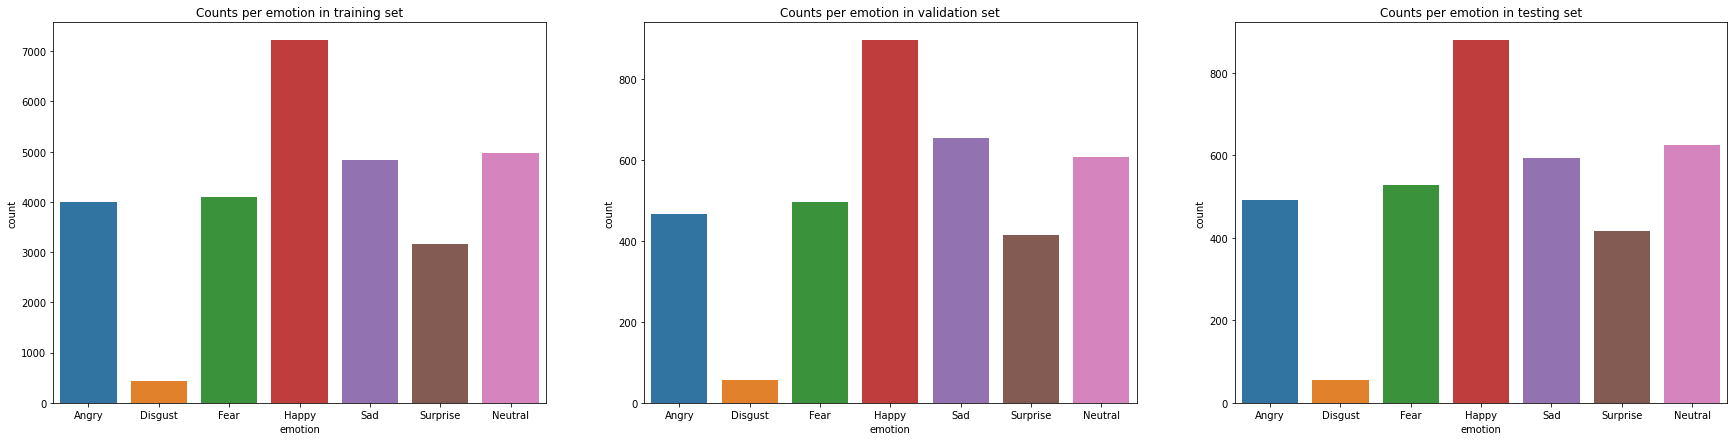

In [13]:
plt.figure(figsize=(30, 7))

plt.subplot(1,3,1)
ax = sns.countplot(Y_train.map(emotions_names), order=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])
ax.set(ylabel="count", xlabel="emotion")
plt.title("Counts per emotion in training set")

plt.subplot(1,3,2)
ax = sns.countplot(Y_validation.map(emotions_names), order=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])
ax.set(ylabel="count", xlabel="emotion")
plt.title("Counts per emotion in validation set")

plt.subplot(1,3,3)
ax = sns.countplot(Y_test.map(emotions_names), order=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])
ax.set(ylabel="count", xlabel="emotion")
plt.title("Counts per emotion in testing set")

## Seeing if there is any null data

In [22]:
print("Is any label null in training set:", Y_train.isnull().any())
print("Is any label null in validation set:", Y_validation.isnull().any())
print("Is any label null in testing set:", Y_test.isnull().any())


Y_train = to_categorical(Y_train, num_classes=7)
# print(Y_train[0].shape)
Y_validation = to_categorical(Y_validation, num_classes=7)
Y_test = to_categorical(Y_test, num_classes=7)

Is any label null in training set: False
Is any label null in validation set: False
Is any label null in testing set: False


CNN

## First model

In [23]:
model = Sequential()
model.add(Conv2D(64, (5,5), padding="Same", activation='relu', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Conv2D(64, (5,5), padding="Same", activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (5,5), padding="Same", activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (5,5), padding="Same", activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.6))

model.add(Dense(7, activation='softmax'))


## Second model

In [ ]:
# model = Sequential()
# model.add(Conv2D(16, (5,5), padding="Same", activation='relu', input_shape=(48,48,1)))
# model.add(BatchNormalization())
# model.add(Conv2D(16, (5,5), padding="Same", activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D((2,2)))
# model.add(Conv2D(32, (5,5), padding="Same", activation='relu'))
# model.add(BatchNormalization())
# model.add(Conv2D(32, (5,5), padding="Same", activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D((2,2)))
# model.add(Flatten())
# model.add(Dense(64, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.6))
# model.add(Dense(64, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.6))

# model.add(Dense(7, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        1664      
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        102464    
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 64)        2

## Specifying the optimizer and callbacks including ReduceLROnPlateau, ModelCheckpoint and EarlyStopping

In [27]:
optimizer = opt.Adam(lr = 0.001)
lr_anneal = ReduceLROnPlateau(monitor = 'val_accuracy', patience=3, factor=0.2, min_lr=1e-6)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## Compiling the model

In [32]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

## Showing one of the images in the test group for the sake of certainty

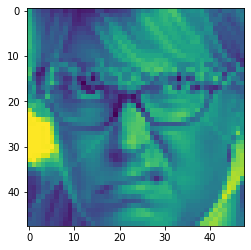

In [ ]:
plt.imshow(X_test[0][:,:,0])

## Training the model

In [36]:
history = model.fit(X_train, Y_train, validation_data=(X_validation, Y_validation), epochs=15, batch_size = 32, callbacks=[lr_anneal, mc, es])

Epoch 1/15
898/898 [==============================] - 1782s 2s/step - loss: 1.8728 - accuracy: 0.2636 - val_loss: 1.6405 - val_accuracy: 0.3547

Epoch 00001: val_accuracy improved from -inf to 0.35469, saving model to best_model.h5
Epoch 2/15
898/898 [==============================] - 1791s 2s/step - loss: 1.6305 - accuracy: 0.3535 - val_loss: 1.5723 - val_accuracy: 0.3990

Epoch 00002: val_accuracy improved from 0.35469 to 0.39900, saving model to best_model.h5
Epoch 3/15
898/898 [==============================] - 1740s 2s/step - loss: 1.5214 - accuracy: 0.4100 - val_loss: 1.5703 - val_accuracy: 0.3954

Epoch 00003: val_accuracy did not improve from 0.39900
Epoch 4/15
898/898 [==============================] - 1731s 2s/step - loss: 1.4094 - accuracy: 0.4561 - val_loss: 1.3462 - val_accuracy: 0.4870

Epoch 00004: val_accuracy improved from 0.39900 to 0.48704, saving model to best_model.h5
Epoch 5/15
898/898 [==============================] - 1712s 2s/step - loss: 1.3340 - accuracy: 0.4

## Plotting loss and accuracy of training process

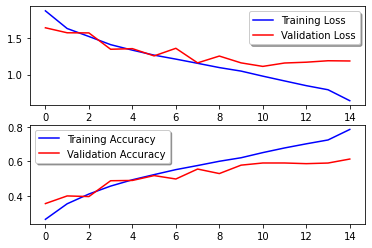

In [37]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training Accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## Plotting confusion matrix

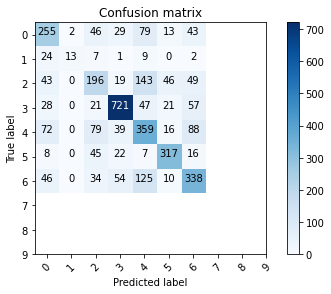

In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_prediction = model.predict(X_validation)
# Convert predictions classes to one hot vectors 
Y_prediction_classes = np.argmax(Y_prediction,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_validation,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_prediction_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

## Loss and accuracy calculation

In [39]:
loss, accuracy = model.evaluate(X_test, Y_test, batch_size=100)
print('Loss:', loss)
print('Test accuracy:', accuracy)

36/36 [==============================] - 49s 1s/step - loss: 1.1563 - accuracy: 0.6066
Loss: 1.156260371208191
Test accuracy: 0.6065756678581238


## A function in order to know the correctness of each prediction

In [40]:
def predict_classes(model, test_imgs, test_labels, emotions_dict,  batch_size  = 32):    

    # Predict class of image using trained model
    class_pred = model.predict(test_imgs, batch_size = batch_size)

    # Convert vector of zeros and ones to label
    labels_pred = np.argmax(class_pred,axis=1)
    true_labels = np.argmax(test_labels, axis=1)

    # Boolean array that indicates whether the predicted label is the true label
    correct = labels_pred == true_labels
    
    # Converting array of labels into emotion names
    pred_emotion_names = pd.Series(labels_pred).map(emotions_dict)
    
    results = {'Predicted_label': labels_pred, 'Predicted_emotion': pred_emotion_names, 'Is_correct' : correct}
    results = pd.DataFrame(results)
    return correct, results


## A function for visualizing random true and false predictions

In [41]:
def visualize_predictions(test, orglabel_names, predlabel_names, correct_arr, valid = True):
    
    if valid == True:
        correct = np.array(np.where(correct_arr == True))[0]
        # Plot 15 randomly selected and correctly predicted images
        show_random(test, Original_emotion = orglabel_names, Predicted_emotion= predlabel_names, random = False, indices = correct)
    else:
        incorrect = np.array(np.where(correct_arr == False))[0]
        # Plot 15 randomly selected and wrongly predicted images
        show_random(test, Original_emotion = orglabel_names, Predicted_emotion= predlabel_names, random = False, indices = incorrect)

## Defining a label for showing the true label of each random image which is showed

In [42]:
correct, results_df = predict_classes(model, X_test, Y_test, emotions_names, batch_size = 1024)
results_df['Original_label'] = data['emotion'][32298:].values
results_df['True_emotion'] = results_df['Original_label'].map(emotions_names)

## Showing some random true predictions

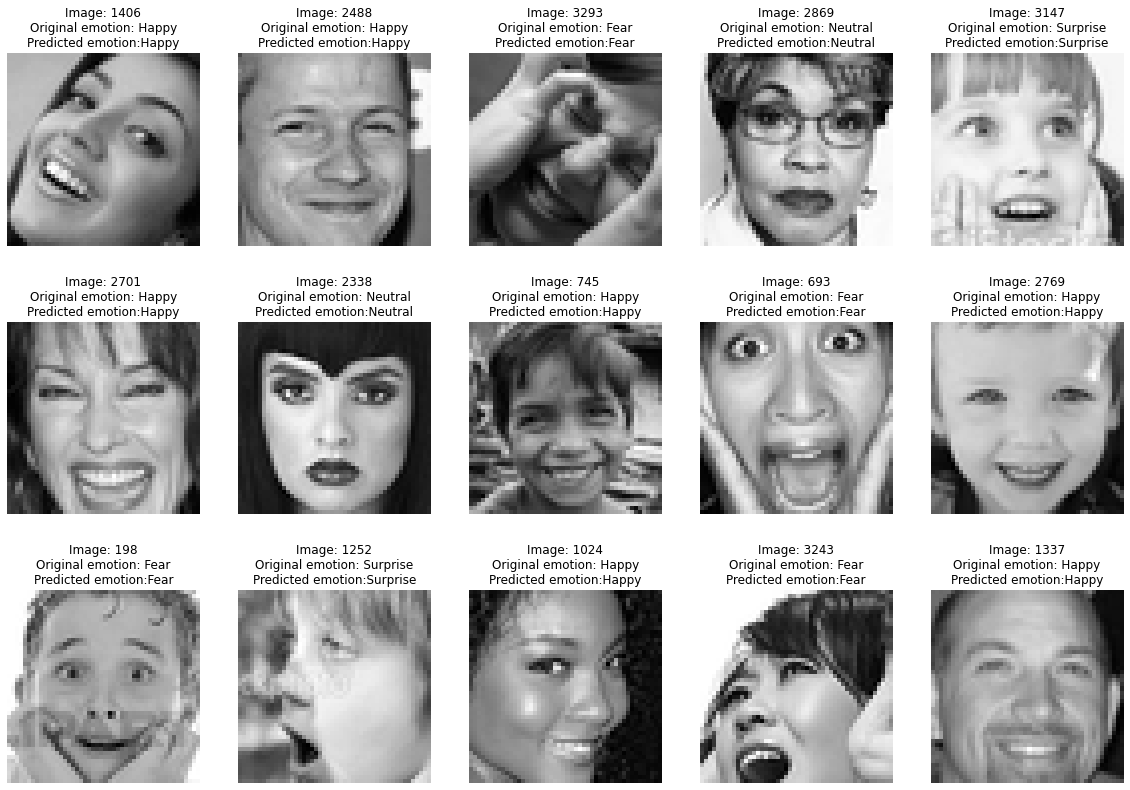

In [43]:
visualize_predictions(X_test, results_df['True_emotion'], results_df['Predicted_emotion'], correct, valid = True)

## Showing some random false predictions

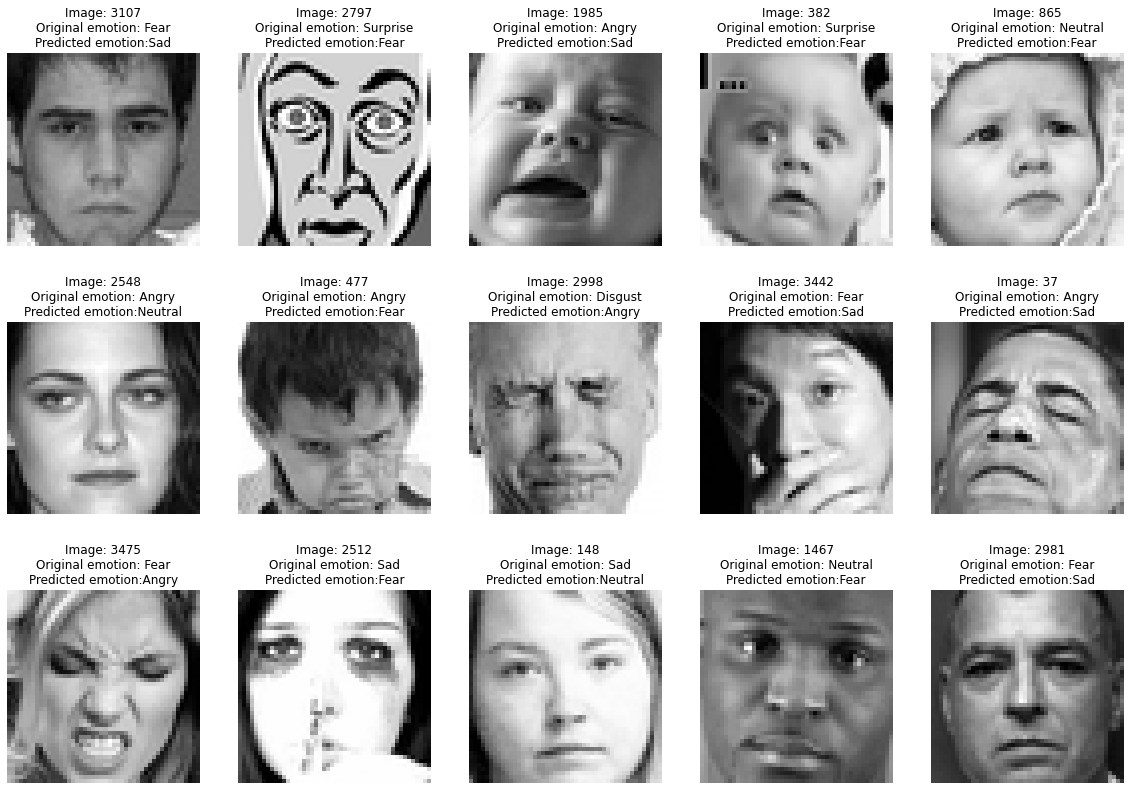

In [44]:
visualize_predictions(X_test, results_df['True_emotion'], results_df['Predicted_emotion'], correct, valid = False)
